# Cyberbulling tweets Clustering

## Table of contents 

// TODO user table of contents extension on jupyter notebook

In [10]:
# Libraries 
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import networkx as nx
import re
import time
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import random 
from yellowbrick.cluster import KElbowVisualizer

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Exploratory Data Analysis (EDA) 
- Data Import / Cleaning and Vectorization
- Distribution of datapoints 

In [11]:
# Spotify tracks dataset (for recommendation system)
df = pd.read_csv("Data/cyberbullying_tweets 2.csv", index_col=0)
df = df.dropna()
df = df.reset_index()
df.head(2)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying


In [12]:
# Data Analysis
print(df.shape)
df['cyberbullying_type'].unique()

(47692, 2)


array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [13]:
df['cyberbullying_type'].head

<bound method NDFrame.head of 0        not_cyberbullying
1        not_cyberbullying
2        not_cyberbullying
3        not_cyberbullying
4        not_cyberbullying
               ...        
47687            ethnicity
47688            ethnicity
47689            ethnicity
47690            ethnicity
47691            ethnicity
Name: cyberbullying_type, Length: 47692, dtype: object>

In [14]:
# Define the category you want to drop
category_to_drop = 'other_cyberbullying'

# Filter and create a new DataFrame without the specified category
df = df[df['cyberbullying_type'] != category_to_drop]

In [15]:
# Dataset is too big, 
shuffled_df = df.sample(frac=1, random_state=42)
slice_df = shuffled_df.iloc[:2000]
slice_df = slice_df.reset_index()

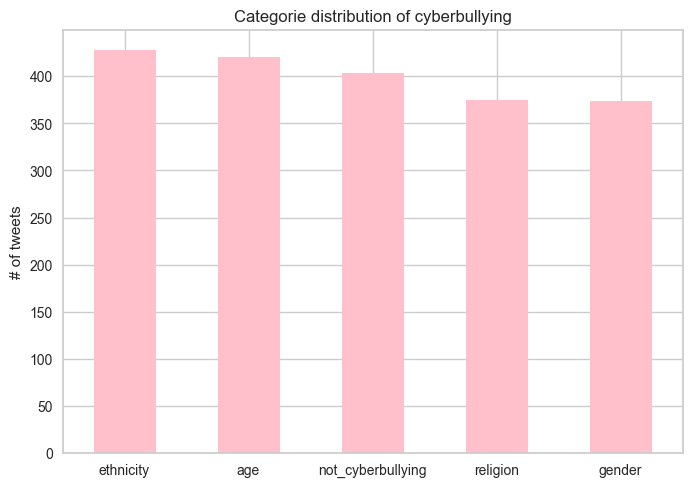

In [16]:
#Plot categories distribution
slice_df['cyberbullying_type'].value_counts().plot.bar(rot=0, color='pink')
plt.title('Categorie distribution of cyberbullying')
plt.ylabel('# of tweets')
None

In [17]:
slice_df.head

<bound method NDFrame.head of       index                                         tweet_text  \
0     40207  I couldn't give two fuck on what niggers think...   
1     13098                           @Dreysander1 Absolutely.   
2       655        Pq vc dorme tarde &gt;&gt;&gt;&gt; bullying   
3      5388  @Phum_Ngcobo eyi buti I'm struggling with dis ...   
4     20795  If you think that the actions of the followers...   
...     ...                                                ...   
1995   6188                   Woo hoo go you humble girls #MKR   
1996  42411  Same. Then that incident introduced me to raci...   
1997   6596  @watan71969 @s_rsantorini630 @pari_passu Seen ...   
1998  10008  @Deanofcomedy nice try. US comedians make rape...   
1999  47325  Okay I feel bad bcs I literally forgot lushlin...   

     cyberbullying_type  
0             ethnicity  
1                gender  
2     not_cyberbullying  
3     not_cyberbullying  
4              religion  
...                 .

In [18]:
# Text Cleaning 

def preprocess_text(text, remove_stopwords):
    """This utility function sanitizes a string by:
        - removing links
        - removing special characters
        - removing numbers
        - removing stopwords
        - transforming in lowercase
        - removing excessive whitespaces
        Args:
            text (str): the input text you want to clean
            remove_stopwords (bool): whether or not to remove stopwords
        Returns:
            str: the cleaned text
        """
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = word_tokenize(text)
        # 2. check if stopword
        tokens = [
            w for w in tokens if not w.lower() in stopwords.words("english")
        ]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text


#Apply this function to the song lyrics ()

t1 = time.time()
print('Starting cleaning of data')
tqdm.pandas(dynamic_ncols=True, smoothing=0.01)
#Use function preprocess_text() for every row, assign results to new column 
slice_df['cleaned'] = slice_df['tweet_text'].progress_apply(lambda x: preprocess_text(x, remove_stopwords=True))
print('Finished cleaning of data')
t2 = time.time()
print(f'Elapsed time for initilization: {t2-t1:.2f}s')

Starting cleaning of data


100%|██████████| 2000/2000 [00:03<00:00, 564.20it/s]

Finished cleaning of data
Elapsed time for initilization: 3.55s


In [19]:
# Text vectorization using sklearn tfidf vectorizer to the preprocessed cleaned data
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to cleaned texts 
X_text = vectorizer.fit_transform(slice_df['cleaned'])
X_text.shape

(2000, 904)

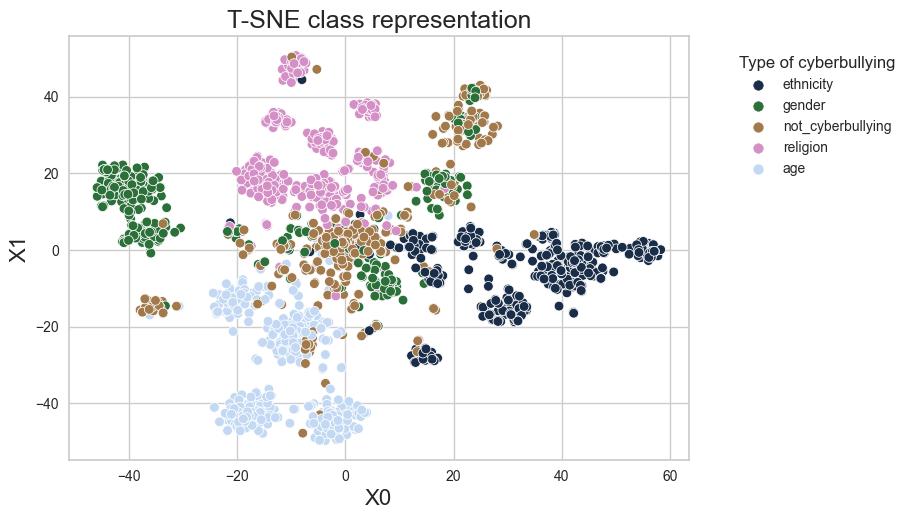

In [20]:
# Reduce the dimensionality of data points to plot the datapoint distribution
pca = PCA(n_components=50, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X_text.toarray())
X_embedded = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(pca_vecs)
                  

plt.title("T-SNE class representation", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=slice_df,
                x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue='cyberbullying_type',
                palette="cubehelix")
#plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(1.05, 1),
           loc='upper left',
           borderaxespad=1,
           title='Type of cyberbullying')
plt.show()

In [21]:
def get_top_keywords(X, clusters, vectorizer, n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    dff = pd.DataFrame(X.todense()).groupby(clusters).mean()  # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out()  # access tf-idf terms
    for i, r in dff.iterrows():
        print('\nCluster {}'.format(i))
         # for each row of the dataframe, find the n terms that have the highest tf idf score
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) 

In [22]:
print('The most central words for each category')
get_top_keywords(X_text, slice_df['cyberbullying_type'], vectorizer, 10)

The most central words for each category

Cluster age
middle,one,like,bullies,girl,girls,bully,bullied,high,school

Cluster ethnicity
ur,tayyoung,white,obama,black,niggers,ass,nigger,fuck,dumb

Cluster gender
men,mkr,like,women,sexist,rt,joke,jokes,gay,rape

Cluster not_cyberbullying
get,de,like,see,go,kat,bully,rt,bullying,mkr

Cluster religion
right,islamic,woman,terrorism,idiots,christian,islam,idiot,muslim,muslims


# Clustering

### Method  1: K-Means

In [23]:
class KMeans:

    def __init__(self, n_clusters, max_iter=300, random_state=1312):
        """
        Parameters
        ----------
        n_clusters : INT
            Number of clusters for K-means
        max_iter : INT, optional
            Number of iterations run by K-means. The default is 300.
        random_state : INT, optional
            Random state for initilization. Used for replication.

        Returns
        -------
        None.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def initCentroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def getCentroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    def getDist(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = np.linalg.norm(X - centroids[k, :], axis=1) #default is frobenius norm, which is equivilant to 2-norm for vectors
            distance[:, k] = np.square(row_norm)
        return distance
    
    def fit(self, X):
        self.centroids = self.initCentroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.getDist(X, old_centroids)
            self.labels = np.argmin(distance, axis=1)
            self.centroids = self.getCentroids(X, self.labels)
            if np.all(old_centroids == self.centroids): #If no updates are done
                break

    def predict(self, X):
        distance = self.getDist(X, self.centroids)
        return np.argmin(distance,axis=1)

In [24]:
### Using own K-means model
kmeans = KMeans(n_clusters=5, max_iter=300, random_state=42)
# fit the model
kmeans.fit(X_text.toarray())
# store cluster labels in a variable
clusters_kmeans = kmeans.predict(X_text.toarray())

print(clusters_kmeans.shape)
#add a column with clusters assigned by kmeans
slice_df['cluster_kmeans_own'] = clusters_kmeans

(2000,)


In [25]:
#### Using Sklearn kmeans 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_text.toarray())
slice_df['cluster_kmeans'] = kmeans.labels_

In [51]:
# Re-importing necessary modules in case the state was reset
import numpy as np
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
from scipy.sparse import csr_matrix
# Re-run the scikit-learn KMeans
kmeans_sklearn = skKMeans(n_clusters=5, random_state=42)
kmeans_sklearn.fit(X_text)
clusters_kmeans_sklearn = kmeans_sklearn.labels_

# Now calculate the metrics for the scikit-learn KMeans
silhouette_sklearn = silhouette_score(X_text, clusters_kmeans_sklearn)
davies_bouldin_sklearn = davies_bouldin_score(X_text.toarray(), clusters_kmeans_sklearn)
calinski_harabasz_sklearn = calinski_harabasz_score(X_text.toarray(), clusters_kmeans_sklearn)

# Compile the results for scikit-learn KMeans
metrics_results_sklearn = {
    'Silhouette Score': silhouette_sklearn,
    'Davies-Bouldin Score': davies_bouldin_sklearn,
    'Calinski-Harabasz Score': calinski_harabasz_sklearn
}

metrics_results_sklearn

{'Silhouette Score': 0.036719281760090004,
 'Davies-Bouldin Score': 5.048788247889868,
 'Calinski-Harabasz Score': 34.58794672366905}

In [26]:
slice_df

,index,tweet_text,cyberbullying_type,cleaned,cluster_kmeans_own,cluster_kmeans
0,40207,I couldn't give two fuck on what niggers think...,ethnicity,give two fuck niggers think still getting band...,2,1
1,13098,@Dreysander1 Absolutely.,gender,dreysander absolutely,0,4
2,655,Pq vc dorme tarde &gt;&gt;&gt;&gt; bullying,not_cyberbullying,pq vc dorme tarde gt gt gt gt bullying,0,4
3,5388,@Phum_Ngcobo eyi buti I'm struggling with dis ...,not_cyberbullying,phum ngcobo eyi buti struggling dis twitter ti...,0,4
4,20795,If you think that the actions of the followers...,religion,think actions followers religion represent thr...,0,4
...,...,...,...,...,...,...
1995,6188,Woo hoo go you humble girls #MKR,not_cyberbullying,woo hoo go humble girls mkr,0,4
1996,42411,Same. Then that incident introduced me to raci...,ethnicity,incident introduced racism catholic school got...,0,4
1997,6596,@watan71969 @s_rsantorini630 @pari_passu Seen ...,not_cyberbullying,watan rsantorini pari passu seen crap lies exa...,0,4
1998,10008,@Deanofcomedy nice try. US comedians make rape...,gender,deanofcomedy nice try us comedians make rape r...,3,3


In [27]:
kmeans.labels_

array([1, 4, 4, ..., 4, 3, 4])

In [28]:
print('The most central words for each category')
get_top_keywords(X_text, kmeans.labels_, vectorizer, 10)

The most central words for each category

Cluster 0
friends,back,bullies,one,like,used,high,middle,school,bully

Cluster 1
shit,bitch,rt,tayyoung,obama,niggers,ass,nigger,dumb,fuck

Cluster 2
getting,one,got,bullies,like,girl,girls,school,bullied,high

Cluster 3
men,makes,like,making,funny,people,joke,jokes,gay,rape

Cluster 4
one,bullying,idiot,islam,muslim,people,muslims,like,rt,mkr


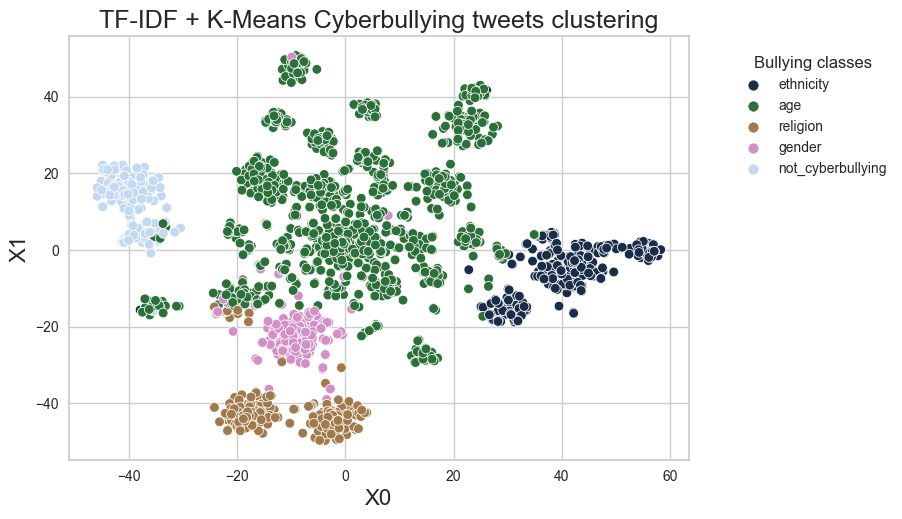

In [29]:
cluster_map_kmeans = {
    0: "gender",
    1: "ethnicity",
    2: "religion",
    3: "not_cyberbullying",
    4: "age"
}
# apply mapping
slice_df['cluster_mapped_kmeans'] = slice_df['cluster_kmeans'].map(cluster_map_kmeans)

plt.title("TF-IDF + K-Means Cyberbullying tweets clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=slice_df,
                x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue='cluster_mapped_kmeans',
                palette="cubehelix")
#plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(1.05, 1),
           loc='upper left',
           borderaxespad=1,
           title='Bullying classes')
plt.show()

> It does an OK job. Only not_cyberbulling is absorbed highly by the religion category


### Method 2: K-Nearest Neighbours

In [56]:
# Shuffle the dataset and take a slice of the first 2000 entries
shuffled_df = df.sample(frac=1, random_state=42)
slice_df = shuffled_df.iloc[:40000]
slice_df = shuffled_df.reset_index(drop=True)

# Now we'll vectorize the 'tweet_text' column of slice_df using the previously mentioned TF-IDF parameters
# Since we don't have the actual 'cleaned' column, we use 'tweet_text' for the purpose of this demonstration
X_text_slice = vectorizer.fit_transform(slice_df['tweet_text'])

# Encode the labels for the sliced dataset
y_labels_slice = label_encoder.fit_transform(slice_df['cyberbullying_type'])

# Check the shapes of the features and labels
X_text_slice.shape, y_labels_slice.shape

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_text_slice, y_labels_slice, test_size=0.2, random_state=42)

# Step 2: Initialize KNN classifier
# We'll start with 5 neighbors, which is the default and a common starting point
knn = KNeighborsClassifier(n_neighbors=10)

# Step 3: Train the KNN classifier
knn.fit(X_train, y_train)

# Step 4: Predict on the test set
y_pred = knn.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, conf_matrix, report



(0.3076387147117019,
 array([[ 107,    0,    0, 7090,    0],
        [   0,  910,    3, 6274,    0],
        [   0,    0, 2886, 4263,    0],
        [   0,    3,   36, 7122,    0],
        [   0,    0,    2, 7173,   14]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.01      0.03      7197\n           1       1.00      0.13      0.22      7187\n           2       0.99      0.40      0.57      7149\n           3       0.22      0.99      0.36      7161\n           4       1.00      0.00      0.00      7189\n\n    accuracy                           0.31     35883\n   macro avg       0.84      0.31      0.24     35883\nweighted avg       0.84      0.31      0.24     35883\n')

### Method 3: DBSCAN

In [57]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN with the chosen parameters
dbscan_chosen = DBSCAN(eps=0.9, min_samples=3)

# Fit the DBSCAN model to the vectorized text data
clusters_chosen = dbscan_chosen.fit_predict(X_text_slice)

# The cluster labels for each point
cluster_labels_chosen = dbscan_chosen.labels_

# Count the number of points in each cluster
clusters_count = pd.Series(cluster_labels_chosen).value_counts().sort_index()

# For interpretation, let's extract some tweet texts from each cluster
# We will create a DataFrame that includes the cluster labels and the tweet texts
clustered_tweets = pd.DataFrame({'cluster': cluster_labels_chosen, 'tweet_text': slice_df['tweet_text']})

# Sample a few tweets from each cluster for interpretation
sample_tweets_per_cluster = clustered_tweets.groupby('cluster').head(3).sort_values(by='cluster').reset_index(drop=True)

clusters_count, sample_tweets_per_cluster


(-1      34940
  0       2614
  1          4
  2         20
  3         25
         ...  
  324        3
  325        4
  326        3
  327        4
  328        3
 Length: 330, dtype: int64,
      cluster                                         tweet_text
 0         -1  I couldn't give two fuck on what niggers think...
 1         -1                           @Dreysander1 Absolutely.
 2         -1  @Phum_Ngcobo eyi buti I'm struggling with dis ...
 3          0        Pq vc dorme tarde &gt;&gt;&gt;&gt; bullying
 4          0  Disgusting ignorance RT @tayyoung_ FUCK OBAMA,...
 ..       ...                                                ...
 985      327  RT @GrahHarwarddd Call me sexist but I can't s...
 986      327  RT @milkyway40: I'm not sexist, but female spo...
 987      328                       OMG U DUMB ASS NIGGER FUCKS.
 988      328  That nigger is dumb.. RT: @LaLa_S0CRAZY: What ...
 989      328                      You are all dumb nigger fucks
 
 [990 rows x 2 columns])

### Method 4: Spectral clustering

In [58]:
from sklearn.cluster import SpectralClustering

# We will use Spectral Clustering on the same TF-IDF vectorized data
# n_clusters is set to 5 as per previous attempts to maintain consistency
spectral_cluster = SpectralClustering(n_clusters=5, random_state=42, affinity='nearest_neighbors')

# Fit the model to the data
spectral_cluster_labels = spectral_cluster.fit_predict(X_text)

# Calculate the metrics for Spectral Clustering
silhouette_spectral = silhouette_score(X_text, spectral_cluster_labels)
davies_bouldin_spectral = davies_bouldin_score(X_text.toarray(), spectral_cluster_labels)
calinski_harabasz_spectral = calinski_harabasz_score(X_text.toarray(), spectral_cluster_labels)

# Compile the results for Spectral Clustering
metrics_results_spectral = {
    'Silhouette Score': silhouette_spectral,
    'Davies-Bouldin Score': davies_bouldin_spectral,
    'Calinski-Harabasz Score': calinski_harabsz_spectral
}

metrics_results_spectral

{'Silhouette Score': -0.020009455863582118,
 'Davies-Bouldin Score': 2.197798383487388,
 'Calinski-Harabasz Score': 13.467093030141758}

## Analysis of misclasified points

1667


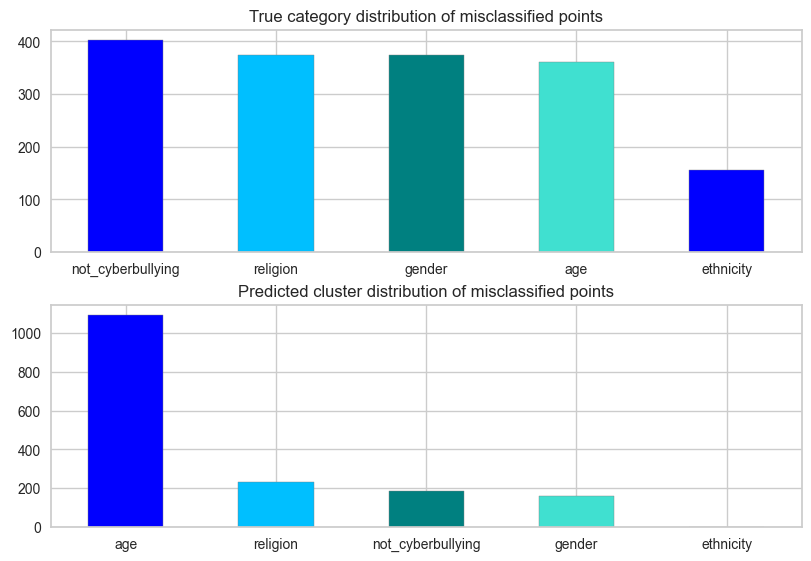

In [30]:
#Find the list of misclassified indexes 
diff_list_kmeans = np.where(slice_df['cyberbullying_type']!= slice_df['cluster_mapped_kmeans'])
misclassified_kmeans = slice_df[slice_df.index.isin(diff_list_kmeans[0])]
print(len(diff_list_kmeans[0]))



###### Figure for visuaization of misclasification #########

figs, ax = plt.subplots(2,layout="constrained")
#Distribution of misclassified points - true category
misclassified_kmeans['cyberbullying_type'].value_counts().plot(ax=ax[0],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue","teal","turquoise"],
                                   edgecolor=["gray"],
                                   title = 'True category distribution of misclassified points' )


#Distribution of misclassified points - predicted cluster
misclassified_kmeans['cluster_mapped_kmeans'].value_counts().plot(ax=ax[1],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue","teal","turquoise"],
                                   edgecolor=["gray"],
                                   title = 'Predicted cluster distribution of misclassified points' )

#plt.savefig('outlier_anal.png', dpi=300)
None

## Clasification
- Neural Network
- Transformer (BERT)

### Neural Network

### BERT 

### SVM

In [61]:
from sklearn.svm import SVC
# Shuffle the dataset and take a slice of the first 2000 entries
shuffled_df = df.sample(frac=1, random_state=42)
slice_df = shuffled_df.iloc[:20000]
slice_df = shuffled_df.reset_index(drop=True)

# Now we'll vectorize the 'tweet_text' column of slice_df using the previously mentioned TF-IDF parameters
# Since we don't have the actual 'cleaned' column, we use 'tweet_text' for the purpose of this demonstration
X_text_slice = vectorizer.fit_transform(slice_df['tweet_text'])

# Encode the labels for the sliced dataset
y_labels_slice = label_encoder.fit_transform(slice_df['cyberbullying_type'])

# Check the shapes of the features and labels
X_text_slice.shape, y_labels_slice.shape

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_text_slice, y_labels_slice, test_size=0.2, random_state=42)

# Initialize the SVM classifier with a linear kernel
svm = SVC(kernel='linear', random_state=42)

# Train the SVM classifier on the training data
svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test)

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

accuracy_svm, conf_matrix_svm, report_svm


(0.9393027338851266,
 array([[1551,    1,    2,   22,    0],
        [   2, 1621,    3,    7,    1],
        [   3,    4, 1391,  180,    6],
        [  49,   13,   65, 1430,   58],
        [   2,    2,    1,   63, 1497]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.97      0.98      0.97      1576\n           1       0.99      0.99      0.99      1634\n           2       0.95      0.88      0.91      1584\n           3       0.84      0.89      0.86      1615\n           4       0.96      0.96      0.96      1565\n\n    accuracy                           0.94      7974\n   macro avg       0.94      0.94      0.94      7974\nweighted avg       0.94      0.94      0.94      7974\n')